In [27]:
import sys
import warnings
from config import *

DATASET = "PF07736"
STEPS = "3"
sys.path.append(f"{ROOT}")

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import random
import pickle
from tqdm import tqdm

import netsurfp2 as nsp2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2

from pattern_matching.utils import *
from pattern_matching.data_extraction import *

## PFAM sequence extraction

In [28]:
if "1" in STEPS:
    extract_data(f"{DATA}/{DATASET}", "full.fasta")

if "2" in STEPS:
    structfam = get_structures(DATA, DATASET)
    pfam_seqs = pd.read_csv(f"{DATA}/{DATASET}/sequences.csv", index_col = 0, usecols = [0,2]).seq
    pfam_seqs = {k.split("/")[0]:v for k,v in pfam_seqs.items()}
    patterns, secondary_structure, c_patterns, n_patterns = build_patterns(pfam_seqs, structfam)

if "3" in STEPS:
    dataset = SecondaryStructureRawDataset(f"{DATA}/{DATASET}/hmm.pkl")
    loader = DataLoader(dataset, batch_size = 1,
                            shuffle=False, drop_last=False, collate_fn = collate_sequences)

    device = "cuda"

    model_ss3 = NetSurfP2(50)
    model_ss3 = model_ss3.to(device)
    model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))

    others, ss8, ss3 = model_ss3.predict(loader)
    pickle.dump(ss3, open(f"{DATA}/{DATASET}/ss3.pkl", "wb"))
    pickle.dump(ss8, open(f"{DATA}/{DATASET}/ss8.pkl", "wb"))
    pickle.dump(others, open(f"{DATA}/{DATASET}/others.pkl", "wb"))


3934it [01:39, 39.40it/s]


In [34]:
dataset

In [29]:
pfam_aligned_seqs = pd.read_csv(f"{DATA}/{DATASET}/sequences.csv", index_col = 0, usecols = [0,1]).aligned_seq
pfam_aligned_seqs = {k.split("/")[0]:np.array([int(i in AA) for i in v]) for k,v in pfam_aligned_seqs.items()}

In [20]:
dataset


profiles



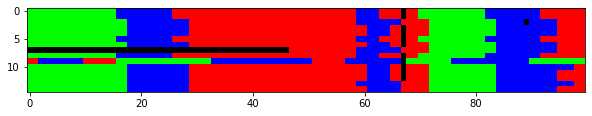

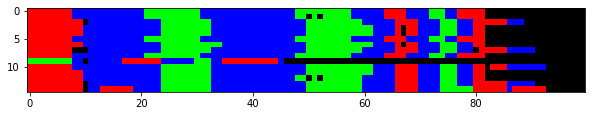


extended profile



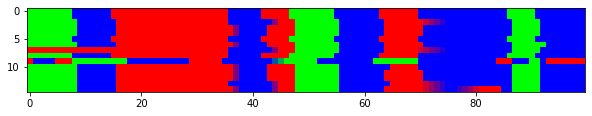

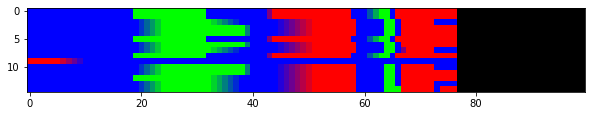


extended mean profile



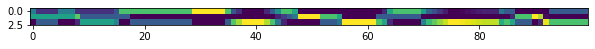

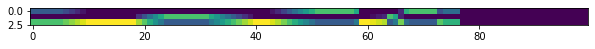


extended argmax profile



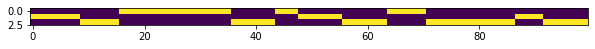

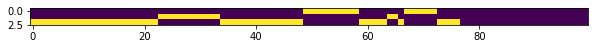

In [51]:
N = 177
aligned_seqs = np.zeros((len(secondary_structure), 100*(N//100+1), 3))

weights=[]
idxs = []
for i, (k, (key, struct,secondary_number,pos_Y, weight)) in enumerate(secondary_structure.items()):
    idx = np.where(pfam_aligned_seqs[key] > 0)[0]
    idxs.append(idx)
    aligned_seqs[i, idx[pos_Y]] = to_onehot(struct, (None,3))
    weights.append(weight)
weights = np.array(weights)

aligned_seqs2 = np.zeros((len(secondary_structure), 100*(N//100+1), 3))
aligned_seqs2 = aligned_seqs.copy()
for k in range(len(secondary_structure)):
    idx = np.where(aligned_seqs[k]>0)[0]
    before, after, x, y, cursor = aligned_seqs[k,idx[0]], aligned_seqs[k,idx[1]], idx[0], idx[1], 2
    for i in range(N):
        if i < x:
            aligned_seqs2[k,i] = before
        elif i > y:
            aligned_seqs2[k,i] = after
        elif i == y and cursor < len(idx):
            x = y; y = idx[cursor]; cursor += 1
            before = after; after = aligned_seqs[k,y]
        elif i == x:
            ()
        else:
            t = (i-x)/(y-x)
            aligned_seqs2[k,i] = t*after + (1-t)*before

 
hotpoints = (aligned_seqs2*weights.reshape(-1,1,1)).sum(0).T
N2 = hotpoints.shape[-1]
hotpoints2 = np.zeros((3, (N2//100 + 1)*100))
hotpoints2[:, :hotpoints.shape[-1]] = hotpoints
idx = np.where(hotpoints2.sum(0)>0)[0]
before, after, x, y, cursor = hotpoints2[:,idx[0]], hotpoints2[:,idx[1]], idx[0], idx[1], 2
for i in range(N2//100 + 1):
    if i < x:
        hotpoints2[:,i] = before
    elif i > y:
        hotpoints2[:,i] = after
    elif i == y and cursor < len(idx):
        x = y; y = idx[cursor]; cursor += 1
        before = after; after = hotpoints2[:,y]
    elif i == x:
        ()
    else:
        t = (i-x)/(y-x)
        hotpoints2[:,i] = t*after + (1-t)*before
    
print(), print("profiles"), print()
idx = np.where(aligned_seqs.sum(0)>0)[0]
for i in range(len(idx)//100 + 1):
    plt.figure(figsize = (10,20))
    x = aligned_seqs[:,idx][:, 100*i:100*(i+1)]
    if x.shape[1] != 100:
        x = np.pad(x, ((0,0),(0,100-x.shape[1]), (0,0)))
    plt.imshow(x)
    plt.show()
    
print(), print("extended profile"), print()
for i in range(N//100 + 1):
    plt.figure(figsize = (10,20))
    x = aligned_seqs2[:, 100*i:100*(i+1)]
    plt.imshow(x)
    plt.show()
        
        
print(), print("extended mean profile"), print()
x = (1+hotpoints2)/(1+hotpoints2).sum(0)
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(hotpoints2[:, 100*i:100*(i+1)])
    plt.show() 
hotpoints2 = (1+hotpoints2)/(1+hotpoints2).sum(0)

print(), print("extended argmax profile"), print()
x = to_onehot(hotpoints2.argmax(0), (None,3)).T
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:,100*i:100*(i+1)])
    plt.show()   

In [26]:
ss3 = pickle.load(open(f"{DATA}/{DATASET}/ss3.pkl", "rb"))


EOFError: Ran out of input

In [38]:
aligned_ss3 = torch.zeros((len(dataset), 3, 100*(N//100+1)))

for i, (k, s) in enumerate(zip(pfam_aligned_seqs.keys(), ss3)):
    idx = np.where(pfam_aligned_seqs[k] > 0)[0]
    aligned_ss3[i, :,idx] = s


extended mean profile



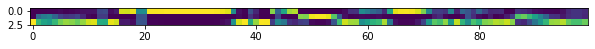

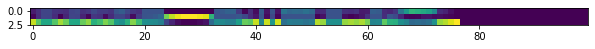


extended mean profile



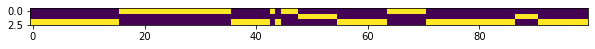

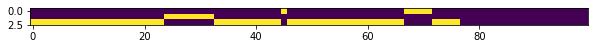

In [46]:
print(), print("extended mean profile"), print()
hotpoints3 = aligned_ss3.sum(0)
x = (1+hotpoints3)/(1+hotpoints3).sum(0)
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 
    
print(), print("extended mean profile"), print()
x = to_onehot(hotpoints3.argmax(0), (None,3)).T
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 


extended mean profile



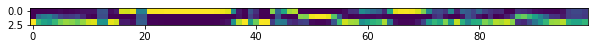

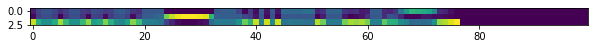


extended mean profile



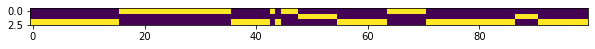

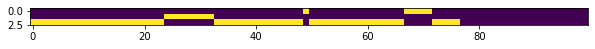

In [56]:
hotpoints4 = (hotpoints3 + hotpoints2[:,:200])/2

print(), print("extended mean profile"), print()
x = (1+hotpoints4)/(1+hotpoints4).sum(0)
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 
    
print(), print("extended mean profile"), print()
x = to_onehot(hotpoints4.argmax(0), (None,3)).T
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:, 100*i:100*(i+1)])
    plt.show() 

In [57]:
sse = to_onehot(hotpoints2[:,:N].argmax(0), (None,3))
ss = np.pad(sse, ((1,1),(0,0)), "constant")
dss = (ss[1:] - ss[:-1])
cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
pat = np.argmax(bbox[:,2:],1)

c_patterns, n_patterns = [],[]
char_pat= "".join(["abc"[x] for x in pat])
if len(char_pat) and char_pat not in c_patterns:
    c_patterns.append(char_pat)
    n_patterns.append(list(pat))

In [58]:
ss_profile = np.log(hotpoints2[:,:N]).T

In [59]:
pickle.dump(ss_profile, open(f"{DATA}/{DATASET}/ss_profile.pkl", "wb"))
pickle.dump((n_patterns, c_patterns, list(patterns.keys())), open(f"{DATA}/{DATASET}/patterns.pkl", "wb"))

## Vizualization

In [27]:
from structure.graphics import visualize_secondary_structure
from structure.data_extraction import fetch_PDB
import matplotlib.pyplot as plt

5VZL


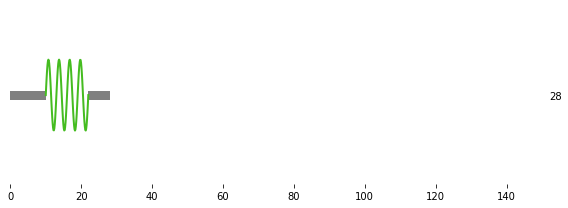

6K4S


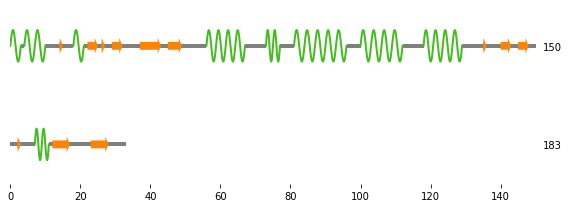

5XBL


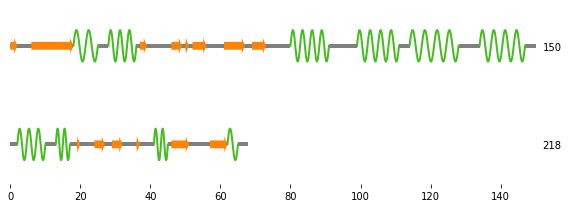

6MCB


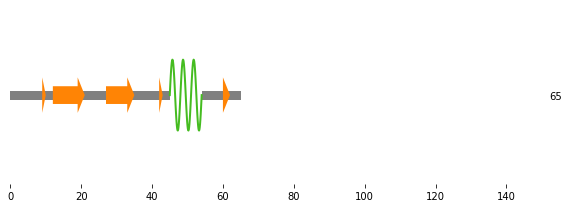

6MCC


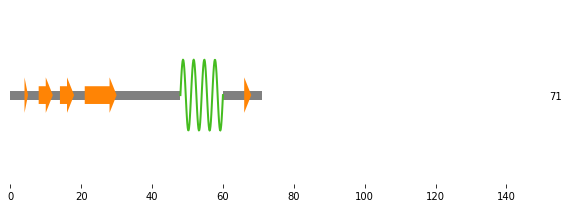

In [28]:
for pdb, pfam, c, start, end in structfam.values():
    try:
        print(pdb)
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        visualize_secondary_structure(sse, 0, 150)
        plt.show()
    except:
        print(pdb, pfam, c, start, end+1)

In [6]:
fetch_PDB('1YIU', 'A', 6, 35)

(array(['c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c',
        'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c',
        'c', 'c', 'c'], dtype='<U1'),
 <biotite.structure.AtomArray at 0x7f2e04c0a310>)

In [1]:
from biotite.structure.io.pdb import get_structure

In [2]:
get_structure('1YIU', 'A', 6, 35)

AttributeError: 'str' object has no attribute 'get_structure'